In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

PATHS = {
    'train': './data/train.csv',
    'test': './data/test.csv',
    'sample_submission': './data/sample_submission.csv',
    'prediction': lambda model_name: f'./prediction/{model_name}_{time.strftime("%Y%m%d%H%M%S")}.csv'
}

In [9]:
# load train data
train = pd.read_csv(PATHS['train'], index_col='id')
test = pd.read_csv(PATHS['test'], index_col='id')
sample_submission = pd.read_csv(PATHS['sample_submission'])
print(train.shape)
train.head()

(20758, 17)


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
id,,,,,,,,,,,,,,,,,
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [10]:
# Print kinds of column value
for column in train.columns:
    if train[column].dtype == np.int64 or train[column].dtype == np.float64:
        continue
    kinds = train[column].unique()
    print(f'{column}: {kinds}')
    print()

Gender: ['Male' 'Female']

family_history_with_overweight: ['yes' 'no']

FAVC: ['yes' 'no']

CAEC: ['Sometimes' 'Frequently' 'no' 'Always']

SMOKE: ['no' 'yes']

SCC: ['no' 'yes']

CALC: ['Sometimes' 'no' 'Frequently']

MTRANS: ['Public_Transportation' 'Automobile' 'Walking' 'Motorbike' 'Bike']

NObeyesdad: ['Overweight_Level_II' 'Normal_Weight' 'Insufficient_Weight'
 'Obesity_Type_III' 'Obesity_Type_II' 'Overweight_Level_I'
 'Obesity_Type_I']



In [11]:
# check missing values
train.isnull().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [12]:
# Gender: ['Male' 'Female']
# family_history_with_overweight: ['yes' 'no']
# FAVC: ['yes' 'no']
# CAEC: ['Sometimes' 'Frequently' 'no' 'Always']
# SMOKE: ['no' 'yes']
# SCC: ['no' 'yes']
# CALC: ['Sometimes' 'no' 'Frequently']
# MTRANS: ['Public_Transportation' 'Automobile' 'Walking' 'Motorbike' 'Bike']
# NObeyesdad: ['Overweight_Level_II' 'Normal_Weight' 'Insufficient_Weight' 'Obesity_Type_III' 'Obesity_Type_II' 'Overweight_Level_I' 'Obesity_Type_I']

# replace string to int
GENDER_MAP = {'Male':0,'Female':1}
FAMILY_HISTORY_WITH_OVERWEIGHT_MAP = {'no':0,'yes':1}
FAVC_MAP = {'no':0,'yes':1}
CAEC_MAP = {'no':0,'Sometimes':1,'Frequently':2,'Always':3}
SMOKE_MAP = {'no':0,'yes':1}
SCC_MAP = {'no':0,'yes':1}
CALC_MAP = {'no':0,'Sometimes':1,'Frequently':2,'Always':3}
MTRANS_MAP = {'Public_Transportation':0,'Automobile':1,'Walking':2,'Motorbike':3,'Bike':4}
N_OBEYESDAD_MAP = {'Insufficient_Weight':0,'Normal_Weight':1,'Overweight_Level_I':2,'Overweight_Level_II':3,'Obesity_Type_I':4,'Obesity_Type_II':5,'Obesity_Type_III':6}
N_OBEYESDAD_MAP_INV = {v: k for k, v in N_OBEYESDAD_MAP.items()}

# apply each map
MAPPING = {
    'Gender': GENDER_MAP,
    'family_history_with_overweight': FAMILY_HISTORY_WITH_OVERWEIGHT_MAP,
    'FAVC': FAVC_MAP,
    'CAEC': CAEC_MAP,
    'SMOKE': SMOKE_MAP,
    'SCC': SCC_MAP,
    'CALC': CALC_MAP,
    'MTRANS': MTRANS_MAP,
    'NObeyesdad': N_OBEYESDAD_MAP
}

train = train.replace(MAPPING)
test = test.replace(MAPPING)

DROP_FEATURES = ['FAVC', 'SCC', 'SMOKE']

In [13]:
TARGET = 'NObeyesdad'
# split data into features and target
X = train.drop(TARGET, axis=1)
y = train[TARGET]

In [14]:
# split data into train and validation
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

# GridSearchCV for LightGBM model
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
model = LGBMClassifier(random_state=0)
param_grid = {
    # 'n_estimators': [100, 200, 300],
    'n_estimators': [75, 100, 125],
    # 'max_depth': [5, 10, 15],
    'max_depth': [3, 5, 7],
    # 'learning_rate': [0.01, 0.05, 0.1]
    'learning_rate': [0.05, 0.1, 0.15]
}
grid_search = GridSearchCV(model, param_grid, cv=3, verbose=2)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_) # {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 125}
model = grid_search.best_estimator_
# predict
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2044
[LightGBM] [Info] Number of data points in the train set: 11070, number of used features: 16
[LightGBM] [Info] Start training from score -2.094551
[LightGBM] [Info] Start training from score -1.913208
[LightGBM] [Info] Start training from score -2.138802
[LightGBM] [Info] Start training from score -2.110823
[LightGBM] [Info] Start training from score -1.964694
[LightGBM] [Info] Start training from score -1.863660
[LightGBM] [Info] Start training from score -1.634594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [15]:

# evaluate
from sklearn.metrics import accuracy_score
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)
print(f'train_acc: {train_acc}')
print(f'val_acc: {val_acc}')

train_acc: 0.9606166445862941
val_acc: 0.9017341040462428


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


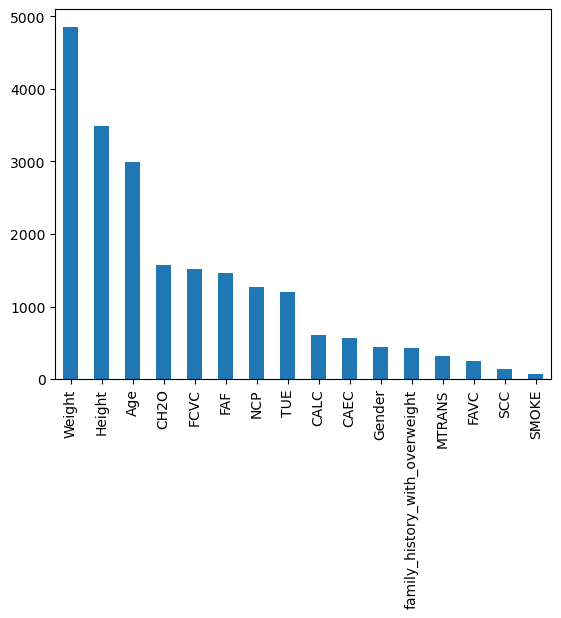

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III


In [16]:
# predict test data
test.head()
test_pred = model.predict(test)

# save the result
submission = sample_submission.copy()
# apply inverse mapping
test_pred = pd.Series(test_pred).map(N_OBEYESDAD_MAP_INV)
submission[TARGET] = test_pred
submission.to_csv(PATHS['prediction']('random_forest'), index=False)

# feature importance
feature_importance = model.feature_importances_
feature_importance = pd.Series(feature_importance, index=X.columns)
feature_importance = feature_importance.sort_values(ascending=False)
feature_importance.plot(kind='bar')
plt.show()

# check the result
submission.head()